In [19]:
import squigglepy as sq
import numpy as np
import pandas as pd
from squigglepy.numbers import K, M, B

sq.set_seed(42)
np.random.seed(42)
np.seterr(invalid='raise')  # Warn on operations involving NaN
N_SAMPLES = 5000

from chip_estimates_utils import (
    estimate_chip_sales,
    estimate_cumulative_chip_sales,
)

In [20]:
# NVIDIA chip types
CHIP_TYPES = ['A100', 'A800', 'H100/H200', 'H800', 'H20', 'B200', 'B300']

# Hardware share of compute revenue (vs cloud/software)
# This is our main source of revenue uncertainty for NVIDIA
HARDWARE_SHARE = sq.to(0.96, 0.99, credibility=80)

In [21]:
# Load revenue and price data from Google Sheets
revenue_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0"
).set_index('Quarter')

prices_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
).set_index('Year')

QUARTERS = revenue_df.index.tolist()

print(f"Loaded {len(QUARTERS)} quarters of data")
print(revenue_df[['Compute revenue']].head())
print()
print(prices_df.head())

Loaded 15 quarters of data
         Compute revenue
Quarter                 
FY23Q1              2.81
FY23Q2              2.86
FY23Q3              2.87
FY23Q4              2.72
FY24Q1              3.35

      A100 low  A100 high  Notes  H100 low  H100 high  Geomean  Notes.1  \
Year                                                                      
2022     10000      15000    NaN     27000      35000  $30,741      NaN   
2023     10000      15000    NaN     27000      35000  $30,741      NaN   
2024     10000      15000    NaN     25000      32000  $28,284      NaN   
2025     10000      15000    NaN     22000      30000  $25,690      NaN   

      B200 low  B200 high Geomean.1  ...  Geomean.2  Notes.3  H20 low  \
Year                                 ...                                
2022       NaN        NaN       NaN  ...        NaN      NaN      NaN   
2023       NaN        NaN       NaN  ...        NaN      NaN      NaN   
2024   33000.0    42000.0   $37,229  ...        NaN   

In [22]:
# ==============================================
# PRICE AND SAMPLING SETUP
# ==============================================

# Map chip types to their column names in the prices CSV
PRICE_COLUMN_MAP = {'H100/H200': 'H100'}

# Fallback prices if not found in CSV
FALLBACK_PRICES = {
    'A100': (10*K, 15*K), 'A800': (10*K, 15*K), 'H100/H200': (20*K, 30*K),
    'H800': (20*K, 30*K), 'H20': (10*K, 15*K), 'B200': (33*K, 42*K), 'B300': (33*K, 42*K)
}

def get_price_year_for_quarter(quarter):
    """Get the calendar year to use for pricing a quarter."""
    start_date = revenue_df.loc[quarter, 'Start Date']
    return pd.to_datetime(start_date).year

def get_price_dist_for_year(chip, year):
    """Get price distribution for a chip in a given year."""
    csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
    low_col, high_col = f'{csv_chip_name} low', f'{csv_chip_name} high'
    
    if low_col in prices_df.columns and high_col in prices_df.columns:
        if year in prices_df.index:
            low = prices_df.loc[year, low_col]
            high = prices_df.loc[year, high_col]
            if pd.notna(low) and pd.notna(high):
                return sq.to(low, high, credibility=80)
    
    return sq.to(*FALLBACK_PRICES.get(chip, (20*K, 30*K)), credibility=80)

def get_price_bounds(chip, year):
    """Get (low, high) price bounds for a chip in a given year, or None if unavailable."""
    csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
    low_col, high_col = f'{csv_chip_name} low', f'{csv_chip_name} high'

    if low_col in prices_df.columns and high_col in prices_df.columns:
        if year in prices_df.index:
            low = prices_df.loc[year, low_col]
            high = prices_df.loc[year, high_col]
            if pd.notna(low) and pd.notna(high):
                return (low, high)
    return None

# Find first year each chip has price data
def find_first_year_with_price(chip):
    """Find the first year with price data for a chip."""
    csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
    low_col = f'{csv_chip_name} low'
    
    if low_col in prices_df.columns:
        for year in sorted(prices_df.index):
            if pd.notna(prices_df.loc[year, low_col]):
                return year
    return min(prices_df.index)

# Build base prices dict
BASE_YEAR = {chip: find_first_year_with_price(chip) for chip in CHIP_TYPES}
BASE_PRICES = {chip: get_price_dist_for_year(chip, BASE_YEAR[chip]) for chip in CHIP_TYPES}

def get_deflation_factor(quarter, chip):
    """Get deflation factor for a chip in a quarter (ratio of current price to base price)."""
    price_year = get_price_year_for_quarter(quarter)
    base_year = BASE_YEAR[chip]

    if price_year <= base_year:
        return 1.0

    base_bounds = get_price_bounds(chip, base_year)
    current_bounds = get_price_bounds(chip, price_year)

    if base_bounds and current_bounds:
        return np.sqrt((current_bounds[0] * current_bounds[1]) / (base_bounds[0] * base_bounds[1]))
    return 1.0

# ==============================================
# SAMPLING FUNCTIONS
# ==============================================

def sample_revenue(quarter):
    """Return hardware revenue for a quarter (with uncertainty)."""
    return revenue_df.loc[quarter, 'Compute revenue'] * B * (HARDWARE_SHARE @ 1)

def sample_shares(quarter):
    """Get chip shares for a quarter (no uncertainty - directly from spreadsheet)."""
    return {chip: revenue_df.loc[quarter, f'{chip} share'] for chip in CHIP_TYPES}

def sample_base_price(chip):
    """Sample base price for a chip (from its first available year)."""
    return BASE_PRICES[chip] @ 1

# Cache price distributions by (chip, year)
PRICE_DIST_CACHE = {}

def sample_price(quarter, chip):
    """Sample price for a chip in a quarter."""
    year = get_price_year_for_quarter(quarter)
    cache_key = (chip, year)
    if cache_key not in PRICE_DIST_CACHE:
        PRICE_DIST_CACHE[cache_key] = get_price_dist_for_year(chip, year)
    return PRICE_DIST_CACHE[cache_key] @ 1

print("Price and sampling functions defined.")

Price and sampling functions defined.


In [23]:
# ==============================================
# HYPERSCALER SHARE DATA
# ==============================================

# Load hyperscaler share data from Google Sheets
hyperscaler_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=47001080"
).set_index('Source / Estimate')

# Extract the low and high share rows (as decimals)
low_share_row = hyperscaler_df.loc['Company low share of data center (0.8x)']
high_share_row = hyperscaler_df.loc['Company high share of data center (1.25x)']

# Build hyperscaler share distributions
HYPERSCALERS = ['Microsoft', 'Meta', 'Amazon', 'Alphabet (Google)']

def parse_pct(val):
    """Parse percentage string like '16.91%' to float 0.1691"""
    return float(val.strip('%')) / 100

HYPERSCALER_SHARES = {
    company: sq.to(parse_pct(low_share_row[company]), parse_pct(high_share_row[company]), credibility=80)
    for company in HYPERSCALERS
}

# Hyperscaler discount factor: hyperscalers pay 5-10% less than neoclouds (rest of market).
# Since spreadsheet prices are market averages (not neocloud prices), we need to account
# for the fact that hyperscalers (~48% of market) already pull down the average.
#
# Math: If hyperscalers pay d% less than neoclouds, and hyperscaler market share is h:
#   P_avg = h * P_h + (1-h) * P_neocloud = P_neocloud * (1 - h*d)
#   discount_factor = (1 - h*d) / (1 - d)
#
# With h ≈ 0.48, d = 5-10%:
#   d=5%:  (1 - 0.48*0.05) / (1 - 0.05) = 0.976 / 0.95 ≈ 1.027
#   d=10%: (1 - 0.48*0.10) / (1 - 0.10) = 0.952 / 0.90 ≈ 1.058
HYPERSCALER_DISCOUNT_FACTOR = sq.to(1.03, 1.06)

# China-spec chips that US hyperscalers don't buy
CHINA_CHIPS = ['H20', 'H800', 'A800']
US_CHIPS = ['A100', 'H100/H200', 'B200', 'B300']

print("Hyperscaler Share Distributions (of total DC revenue):")
for company, dist in HYPERSCALER_SHARES.items():
    print(f"  {company}: {dist.x*100:.2f}% - {dist.y*100:.2f}%")
print(f"\nHyperscaler discount factor: {HYPERSCALER_DISCOUNT_FACTOR.x:.2f} - {HYPERSCALER_DISCOUNT_FACTOR.y:.2f}")

Hyperscaler Share Distributions (of total DC revenue):
  Microsoft: 16.91% - 26.42%
  Meta: 8.68% - 13.57%
  Amazon: 6.43% - 10.05%
  Alphabet (Google): 6.32% - 9.87%

Hyperscaler discount factor: 1.03 - 1.06


In [24]:
# ==============================================
# HYPERSCALER CHIP ALLOCATION BY QUARTER
# ==============================================

def get_china_chip_share(quarter):
    """Get the share of revenue from China-spec chips for a quarter."""
    china_share = 0
    for chip in CHINA_CHIPS:
        share_col = f'{chip} share'
        if share_col in revenue_df.columns:
            share = revenue_df.loc[quarter, share_col]
            if pd.notna(share):
                china_share += share
    return china_share

def get_non_china_chip_share(quarter):
    """Get the share of revenue from non-China chips for a quarter."""
    return 1 - get_china_chip_share(quarter)

# Baseline China share: the average level of China sales across all quarters.
# The hyperscaler share estimates (HYPERSCALER_SHARES) are of total Nvidia DC revenue,
# implicitly assuming this average level of China sales.
BASELINE_CHINA_SHARE = np.mean([get_china_chip_share(q) for q in QUARTERS])

# Print China chip share by quarter for reference
print("China Chip Share by Quarter:")
print("-" * 40)
for quarter in QUARTERS:
    china_share = get_china_chip_share(quarter)
    if china_share > 0:
        print(f"  {quarter}: {china_share*100:.1f}%")
    else:
        print(f"  {quarter}: 0%")
print(f"\nBaseline China share (avg across all quarters): {BASELINE_CHINA_SHARE*100:.1f}%")

China Chip Share by Quarter:
----------------------------------------
  FY23Q1: 0%
  FY23Q2: 0%
  FY23Q3: 0%
  FY23Q4: 19.0%
  FY24Q1: 19.0%
  FY24Q2: 19.0%
  FY24Q3: 19.0%
  FY24Q4: 0%
  FY25Q1: 13.0%
  FY25Q2: 13.0%
  FY25Q3: 13.0%
  FY25Q4: 13.0%
  FY26Q1: 13.0%
  FY26Q2: 2.0%
  FY26Q3: 0%

Baseline China share (avg across all quarters): 9.5%


In [ ]:
# ==============================================
# TOTAL CHIP SALES + HYPERSCALER ALLOCATION
# ==============================================

# First, compute total chip sales using estimate_cumulative_chip_sales
total_quarterly_samples = estimate_cumulative_chip_sales(
    quarters=QUARTERS,
    chip_types=CHIP_TYPES,
    sample_revenue=sample_revenue,
    sample_shares=sample_shares,
    sample_base_price=sample_base_price,
    get_deflation_factor=get_deflation_factor,
    sample_revenue_uncertainty=lambda: HARDWARE_SHARE @ 1,
    n_samples=N_SAMPLES,
)

def allocate_to_hyperscalers(
    quarterly_chip_samples,
    quarters,
    chip_types,
    hyperscalers,
    hyperscaler_shares,
    hyperscaler_discount_dist,
    get_non_china_share,
    china_chips,
    baseline_china_share=0.0,
    n_samples=5000,
):
    """
    Allocate chip samples to hyperscalers based on their share of non-China revenue.
    
    Takes the output of estimate_cumulative_chip_sales (total chips per quarter per type)
    and applies two adjustments per hyperscaler:
      a. China boost: hyperscalers' share of Nvidia $ increases when China buys less
      b. Non-China rescale: hyperscalers only buy non-China chips, so their share of
         those specific chips is higher than their share of total revenue
    
    Returns:
        dict of {hyperscaler: {quarter: {chip: np.array of samples}}}
    """
    # Presample correlated params (one value per sample, reused across all quarters)
    share_samples = {
        company: np.array([dist @ 1 for _ in range(n_samples)])
        for company, dist in hyperscaler_shares.items()
    }
    discount_samples = np.array([hyperscaler_discount_dist @ 1 for _ in range(n_samples)])

    results = {co: {q: {} for q in quarters} for co in hyperscalers}

    for quarter in quarters:
        non_china_share = get_non_china_share(quarter)

        # Two separate adjustments to hyperscaler share (not double-counting):
        #
        # 1. China boost (dollar share adjustment):
        #    When China buys less than the baseline, US hyperscalers' share of
        #    Nvidia's total $ revenue goes up because they absorb freed supply.
        #    e.g. if baseline China = 10% and current = 0%, non_china goes from
        #    90% to 100%, so china_boost = 100%/90% ≈ 1.11x on their $ share.
        china_boost = non_china_share / (1 - baseline_china_share) if baseline_china_share > 0 else 1.0

        for chip in chip_types:
            total_chips = quarterly_chip_samples[quarter][chip]

            for company in hyperscalers:
                if chip not in china_chips:
                    # Start with base share of total Nvidia DC revenue
                    share_of_total = share_samples[company]
                    # Adjust for China: hyperscalers buy more $ when China buys less
                    share_of_total_adjusted = share_of_total * china_boost
                    # Rescale to non-China chips: hyperscalers only buy non-China chips,
                    # so their share of those chips is higher than their share of total $
                    share_of_non_china_chips = share_of_total_adjusted / non_china_share
                    # Volume discount: hyperscalers get more chips per $ than average
                    adjusted_share = share_of_non_china_chips * discount_samples
                    results[company][quarter][chip] = total_chips * adjusted_share
                else:
                    # China chips: hyperscalers get 0
                    results[company][quarter][chip] = np.zeros(n_samples)

    return results

# Allocate to hyperscalers using the total chip samples
hyperscaler_results = allocate_to_hyperscalers(
    quarterly_chip_samples=total_quarterly_samples,
    quarters=QUARTERS,
    chip_types=CHIP_TYPES,
    hyperscalers=HYPERSCALERS,
    hyperscaler_shares=HYPERSCALER_SHARES,
    hyperscaler_discount_dist=HYPERSCALER_DISCOUNT_FACTOR,
    get_non_china_share=get_non_china_chip_share,
    china_chips=CHINA_CHIPS,
    baseline_china_share=BASELINE_CHINA_SHARE,
    n_samples=N_SAMPLES,
)

print("Simulation complete.")

In [26]:
hyperscaler_results

{'Microsoft': {'FY23Q1': {'A100': array([54614.33031139, 57792.21330826, 64400.26687845, ...,
          67896.16973235, 92838.66353031, 53606.14554138]),
   'A800': array([0, 0, 0, ..., 0, 0, 0]),
   'H100/H200': array([0, 0, 0, ..., 0, 0, 0]),
   'H800': array([0, 0, 0, ..., 0, 0, 0]),
   'H20': array([0, 0, 0, ..., 0, 0, 0]),
   'B200': array([0, 0, 0, ..., 0, 0, 0]),
   'B300': array([0, 0, 0, ..., 0, 0, 0])},
  'FY23Q2': {'A100': array([57549.85007174, 70838.92720514, 58635.82905758, ...,
          63071.76412904, 43819.29931092, 70000.93910299]),
   'A800': array([0, 0, 0, ..., 0, 0, 0]),
   'H100/H200': array([0, 0, 0, ..., 0, 0, 0]),
   'H800': array([0, 0, 0, ..., 0, 0, 0]),
   'H20': array([0, 0, 0, ..., 0, 0, 0]),
   'B200': array([0, 0, 0, ..., 0, 0, 0]),
   'B300': array([0, 0, 0, ..., 0, 0, 0])},
  'FY23Q3': {'A100': array([44815.95913149, 62187.12176456, 72501.56221964, ...,
          47362.81724662, 45110.78045317, 53398.60853922]),
   'A800': array([0, 0, 0, ..., 0, 0, 

In [27]:
# ==============================================
# CHIP SPECS FOR H100e CALCULATION (hardcoded)
# ==============================================

# TOPS: 8-bit OP/s / 1e12, TDP: watts
CHIP_SPECS = {
    'A100':      {'tops': 624,  'tdp': 400},
    'A800':      {'tops': 312,  'tdp': 400},
    'H100/H200': {'tops': 1979, 'tdp': 700},
    'H800':      {'tops': 1979, 'tdp': 700},
    'H20':       {'tops': 296,  'tdp': 400},
    'B200':      {'tops': 5000, 'tdp': 1200},
    'B300':      {'tops': 5000, 'tdp': 1400},
}

H100_TOPS = 1979  # Reference for H100-equivalent calculation

print("Chip specs for H100e conversion:")
for chip, spec in CHIP_SPECS.items():
    h100e_mult = spec['tops'] / H100_TOPS
    print(f"  {chip}: TOPS={spec['tops']:.0f}, H100e multiplier={h100e_mult:.3f}")

Chip specs for H100e conversion:
  A100: TOPS=624, H100e multiplier=0.315
  A800: TOPS=312, H100e multiplier=0.158
  H100/H200: TOPS=1979, H100e multiplier=1.000
  H800: TOPS=1979, H100e multiplier=1.000
  H20: TOPS=296, H100e multiplier=0.150
  B200: TOPS=5000, H100e multiplier=2.527
  B300: TOPS=5000, H100e multiplier=2.527


In [28]:
# ==============================================
# HYPERSCALER QUARTERLY RESULTS SUMMARY
# ==============================================

def summarize_hyperscaler_quarterly(hyperscaler_results, hyperscalers, quarters, chip_types):
    """Create summary DataFrame with quarterly chip totals per hyperscaler."""
    rows = []
    
    for quarter in quarters:
        row = {'Quarter': quarter}
        
        for company in hyperscalers:
            # Sum across all chip types for this company/quarter
            total_chips = np.zeros(N_SAMPLES)
            for chip in chip_types:
                total_chips += hyperscaler_results[company][quarter][chip]
            
            p50 = int(np.percentile(total_chips, 50))
            row[company] = p50
        
        rows.append(row)
    
    return pd.DataFrame(rows)

# Generate summary
quarterly_summary = summarize_hyperscaler_quarterly(hyperscaler_results, HYPERSCALERS, QUARTERS, CHIP_TYPES)
print("Hyperscaler Chip Allocations by Quarter (median units)")
print("=" * 80)
print(quarterly_summary.to_string(index=False))

# Also show cumulative totals
print("\n" + "=" * 80)
print("Cumulative Totals by Hyperscaler")
print("=" * 80)
print(f"{'Company':<25} {'p5':>12} {'p50':>12} {'p95':>12}")
print("-" * 65)

for company in HYPERSCALERS:
    # Sum across all quarters and chips
    total = np.zeros(N_SAMPLES)
    for quarter in QUARTERS:
        for chip in CHIP_TYPES:
            total += hyperscaler_results[company][quarter][chip]
    
    p5 = int(np.percentile(total, 5))
    p50 = int(np.percentile(total, 50))
    p95 = int(np.percentile(total, 95))
    print(f"{company:<25} {p5:>12,} {p50:>12,} {p95:>12,}")

Hyperscaler Chip Allocations by Quarter (median units)
Quarter  Microsoft   Meta  Amazon  Alphabet (Google)
 FY23Q1      54495  28006   20745              20326
 FY23Q2      55483  28458   21173              20632
 FY23Q3      52392  26837   19939              19456
 FY23Q4      26925  13822   10227              10049
 FY24Q1      29410  15029   11143              10910
 FY24Q2      64193  32860   24395              23895
 FY24Q3      81506  41839   31023              30389
 FY24Q4     116668  59798   44388              43491
 FY25Q1     142264  72896   54028              53025
 FY25Q2     165532  84930   62708              61783
 FY25Q3     203467 103638   76839              75403
 FY25Q4     217168 111401   82670              80880
 FY26Q1     207274 106077   78638              76685
 FY26Q2     219222 112155   83049              81391
 FY26Q3     256906 131826   97826              95877

Cumulative Totals by Hyperscaler
Company                             p5          p50          p9

In [29]:
# ==============================================
# CUMULATIVE RUNNING TOTALS BY HYPERSCALER
# ==============================================
# Build running totals for each hyperscaler across quarters

from chip_estimates_utils import (
    interpolate_samples_to_calendar_quarters,
    compute_running_totals,
)

# Compute running totals for each hyperscaler
hyperscaler_running_totals = {}

for company in HYPERSCALERS:
    cumulative_so_far = {chip: np.zeros(N_SAMPLES) for chip in CHIP_TYPES}
    company_running = {}
    
    for quarter in QUARTERS:
        for chip in CHIP_TYPES:
            cumulative_so_far[chip] = cumulative_so_far[chip] + hyperscaler_results[company][quarter][chip]
        company_running[quarter] = {chip: cumulative_so_far[chip].copy() for chip in CHIP_TYPES}
    
    hyperscaler_running_totals[company] = company_running

print("Computed cumulative running totals for each hyperscaler.")

Computed cumulative running totals for each hyperscaler.


In [30]:
# ==============================================
# INTERPOLATE TO CALENDAR QUARTERS
# ==============================================
# Convert fiscal quarter results to calendar quarters for each hyperscaler

# Build quarter_dates from revenue_df
quarter_dates = {q: (revenue_df.loc[q, 'Start Date'], revenue_df.loc[q, 'End Date']) 
                 for q in QUARTERS}

# Interpolate per-quarter samples to calendar quarters for each hyperscaler
hyperscaler_calendar_quarterly = {}
hyperscaler_calendar_running = {}

for company in HYPERSCALERS:
    # First interpolate the per-quarter data
    calendar_quarterly = interpolate_samples_to_calendar_quarters(
        hyperscaler_results[company], quarter_dates
    )
    hyperscaler_calendar_quarterly[company] = calendar_quarterly
    
    # Then compute running totals from calendar quarters
    hyperscaler_calendar_running[company] = compute_running_totals(calendar_quarterly)

CALENDAR_QUARTERS = list(hyperscaler_calendar_running[HYPERSCALERS[0]].keys())
print(f"Interpolated to {len(CALENDAR_QUARTERS)} calendar quarters: {CALENDAR_QUARTERS[0]} to {CALENDAR_QUARTERS[-1]}")

Interpolated to 16 calendar quarters: Q1 2022 to Q4 2025


In [31]:
# ==============================================
# COMPUTE H100e BY HYPERSCALER (CALENDAR QUARTERS)
# ==============================================

def compute_h100e_samples(running_totals, chip_specs, h100_tops=1979):
    """
    Compute H100e samples for each calendar quarter from cumulative chip samples.
    
    Returns:
        dict of {calendar_quarter: np.array of H100e samples}
    """
    h100e_results = {}
    for cq, chip_samples in running_totals.items():
        n_samples = len(next(iter(chip_samples.values())))
        h100e_total = np.zeros(n_samples)
        
        for chip, samples in chip_samples.items():
            if chip in chip_specs:
                tops = chip_specs[chip]['tops']
                h100e_total += samples * (tops / h100_tops)
        
        h100e_results[cq] = h100e_total
    return h100e_results

# Compute H100e for each hyperscaler
hyperscaler_h100e = {}
for company in HYPERSCALERS:
    hyperscaler_h100e[company] = compute_h100e_samples(
        hyperscaler_calendar_running[company], CHIP_SPECS, H100_TOPS
    )

print("Computed H100e equivalents for each hyperscaler by calendar quarter.")

Computed H100e equivalents for each hyperscaler by calendar quarter.


In [32]:
# ==============================================
# H100e CUMULATIVE BY HYPERSCALER - SUMMARY TABLE
# ==============================================

print("Cumulative H100e Compute by Hyperscaler (Calendar Quarters)")
print("=" * 100)
print(f"{'Quarter':<10} | {'Microsoft':^26} | {'Meta':^26} | {'Amazon':^26} | {'Alphabet':^26}")
print(f"{'':10} | {'p5':>7} {'p50':>8} {'p95':>9} | {'p5':>7} {'p50':>8} {'p95':>9} | {'p5':>7} {'p50':>8} {'p95':>9} | {'p5':>7} {'p50':>8} {'p95':>9}")
print("-" * 100)

for cq in CALENDAR_QUARTERS:
    row = f"{cq:<10} |"
    for company in HYPERSCALERS:
        samples = hyperscaler_h100e[company][cq]
        p5, p50, p95 = [int(np.percentile(samples, p)) for p in [5, 50, 95]]
        # Format in thousands for readability
        row += f" {p5/1000:>7.1f}k {p50/1000:>7.1f}k {p95/1000:>7.1f}k |"
    print(row)

# Print final totals
print("=" * 100)
print("\nFinal Cumulative H100e (end of period):")
print(f"{'Company':<25} {'p5':>12} {'p50':>12} {'p95':>12}")
print("-" * 55)
for company in HYPERSCALERS:
    final_samples = hyperscaler_h100e[company][CALENDAR_QUARTERS[-1]]
    p5 = int(np.percentile(final_samples, 5))
    p50 = int(np.percentile(final_samples, 50))
    p95 = int(np.percentile(final_samples, 95))
    print(f"{company:<25} {p5:>12,} {p50:>12,} {p95:>12,}")

Cumulative H100e Compute by Hyperscaler (Calendar Quarters)
Quarter    |         Microsoft          |            Meta            |           Amazon           |          Alphabet         
           |      p5      p50       p95 |      p5      p50       p95 |      p5      p50       p95 |      p5      p50       p95
----------------------------------------------------------------------------------------------------
Q1 2022    |     7.7k    11.3k    16.8k |     3.9k     5.8k     8.6k |     2.9k     4.3k     6.3k |     2.9k     4.2k     6.2k |
Q2 2022    |    20.6k    28.9k    41.2k |    10.6k    14.8k    20.9k |     7.9k    11.0k    15.4k |     7.7k    10.8k    15.2k |
Q3 2022    |    34.1k    47.1k    65.4k |    17.6k    24.2k    33.5k |    13.1k    17.9k    24.5k |    12.7k    17.6k    24.3k |
Q4 2022    |    46.8k    63.9k    87.8k |    24.2k    32.7k    45.1k |    17.9k    24.3k    32.9k |    17.5k    23.8k    32.5k |
Q1 2023    |    60.8k    82.4k   112.4k |    31.4k    42.2k    57.7k 

In [33]:
# ==============================================
# H100e CUMULATIVE AS DATAFRAME (for export)
# ==============================================

def get_calendar_quarter_dates(cal_q):
    """Return (start_date, end_date) strings for a calendar quarter like 'Q1 2024'."""
    parts = cal_q.split()
    q_num = int(parts[0][1])
    year = int(parts[1])
    if q_num == 1:
        return f"1/1/{year}", f"3/31/{year}"
    elif q_num == 2:
        return f"4/1/{year}", f"6/30/{year}"
    elif q_num == 3:
        return f"7/1/{year}", f"9/30/{year}"
    else:
        return f"10/1/{year}", f"12/31/{year}"

rows = []
for cq in CALENDAR_QUARTERS:
    start_date, end_date = get_calendar_quarter_dates(cq)
    for company in HYPERSCALERS:
        h100e_samples = hyperscaler_h100e[company][cq]
        
        # Also compute total units for reference
        unit_samples = sum(
            hyperscaler_calendar_running[company][cq][chip] 
            for chip in CHIP_TYPES
        )
        
        rows.append({
            'Name': f"{company} Nvidia cumulative through {cq}",
            'Owner': company,
            'Start date': start_date,
            'End date': end_date,
            'H100e (5th percentile)': int(np.percentile(h100e_samples, 5)),
            'H100e (median)': int(np.percentile(h100e_samples, 50)),
            'H100e (95th percentile)': int(np.percentile(h100e_samples, 95)),
            'Units (5th percentile)': int(np.percentile(unit_samples, 5)),
            'Units (median)': int(np.percentile(unit_samples, 50)),
            'Units (95th percentile)': int(np.percentile(unit_samples, 95)),
        })

hyperscaler_h100e_df = pd.DataFrame(rows)
print(f"Created DataFrame with {len(hyperscaler_h100e_df)} rows")
hyperscaler_h100e_df.tail(8)

Created DataFrame with 64 rows


,Name,Owner,Start date,End date,H100e (5th percentile),H100e (median),H100e (95th percentile),Units (5th percentile),Units (median),Units (95th percentile)
56,Microsoft Nvidia cumulative through Q3 2025,Microsoft,7/1/2025,9/30/2025,1890614,2528420,3374487,1368610,1832585,2448886
57,Meta Nvidia cumulative through Q3 2025,Meta,7/1/2025,9/30/2025,972242,1291445,1733189,705221,934405,1258348
58,Amazon Nvidia cumulative through Q3 2025,Amazon,7/1/2025,9/30/2025,718175,955954,1273696,522268,693095,920742
59,Alphabet (Google) Nvidia cumulative through Q3...,Alphabet (Google),7/1/2025,9/30/2025,703253,936764,1251201,508819,679412,910467
60,Microsoft Nvidia cumulative through Q4 2025,Microsoft,10/1/2025,12/31/2025,2018256,2702386,3612314,1421513,1906047,2546142
61,Meta Nvidia cumulative through Q4 2025,Meta,10/1/2025,12/31/2025,1041498,1381467,1856185,733796,973081,1308776
62,Amazon Nvidia cumulative through Q4 2025,Amazon,10/1/2025,12/31/2025,769148,1022982,1365412,543587,720624,958014
63,Alphabet (Google) Nvidia cumulative through Q4...,Alphabet (Google),10/1/2025,12/31/2025,750490,1003220,1338475,529813,706660,945724


In [ ]:
# ==============================================
# COMPUTE TOTAL NVIDIA H100e (for "Other" calculation)
# ==============================================

# Reuse total_quarterly_samples from earlier (same underlying chip count samples
# that were allocated to hyperscalers, so "Other" = Total - hyperscalers is exact)

# Interpolate to calendar quarters and compute running totals
total_calendar_quarterly = interpolate_samples_to_calendar_quarters(total_quarterly_samples, quarter_dates)
total_calendar_running = compute_running_totals(total_calendar_quarterly)

# Compute total H100e
total_h100e = compute_h100e_samples(total_calendar_running, CHIP_SPECS, H100_TOPS)

# Compute "Other" = Total - sum(hyperscalers)
other_h100e = {}
for cq in CALENDAR_QUARTERS:
    hyperscaler_sum = sum(hyperscaler_h100e[company][cq] for company in HYPERSCALERS)
    other_h100e[cq] = total_h100e[cq] - hyperscaler_sum

print("Computed total Nvidia H100e and 'Other' category")
print(f"\nFinal totals ({CALENDAR_QUARTERS[-1]}):")
print(f"  Total Nvidia H100e (p50): {int(np.percentile(total_h100e[CALENDAR_QUARTERS[-1]], 50)):,}")
print(f"  Hyperscalers sum (p50):   {int(np.percentile(sum(hyperscaler_h100e[c][CALENDAR_QUARTERS[-1]] for c in HYPERSCALERS), 50)):,}")
print(f"  Other (p50):              {int(np.percentile(other_h100e[CALENDAR_QUARTERS[-1]], 50)):,}")

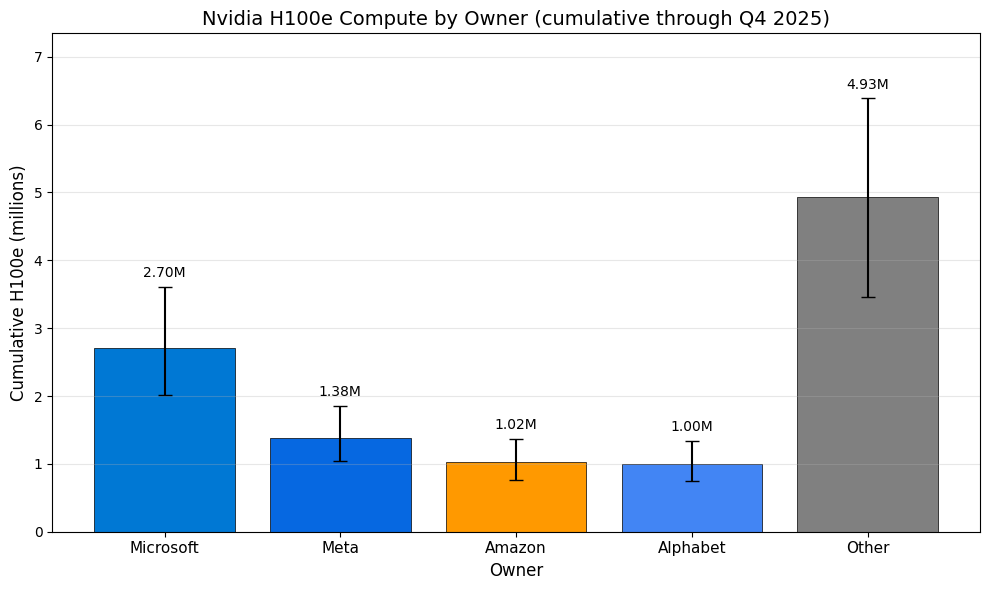


Big 4 share of total Nvidia H100e (Q4 2025):
  Combined: 55.5% (90% CI: 45.9% - 67.1%)
  Microsoft: 24.3% (90% CI: 17.8% - 33.1%)
  Meta: 12.4% (90% CI: 9.2% - 17.0%)
  Amazon: 9.2% (90% CI: 6.8% - 12.5%)
  Alphabet (Google): 9.0% (90% CI: 6.6% - 12.2%)


In [37]:
# ==============================================
# BAR CHART: H100e BY OWNER (with error bars)
# ==============================================

import matplotlib.pyplot as plt

# Use final calendar quarter for the comparison
final_cq = CALENDAR_QUARTERS[-1]

# Gather data for each category
categories = HYPERSCALERS + ['Other']
medians = []
errors_low = []
errors_high = []

for cat in categories:
    if cat == 'Other':
        samples = other_h100e[final_cq]
    else:
        samples = hyperscaler_h100e[cat][final_cq]
    
    p5 = np.percentile(samples, 5)
    p50 = np.percentile(samples, 50)
    p95 = np.percentile(samples, 95)
    
    medians.append(p50)
    errors_low.append(p50 - p5)
    errors_high.append(p95 - p50)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(categories))
colors = ['#0078D4', '#0668E1', '#FF9900', '#4285F4', '#808080']  # MS blue, Meta blue, AWS orange, Google blue, gray

bars = ax.bar(x, np.array(medians) / 1e6, 
              yerr=[np.array(errors_low) / 1e6, np.array(errors_high) / 1e6],
              capsize=5, color=colors, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Owner', fontsize=12)
ax.set_ylabel('Cumulative H100e (millions)', fontsize=12)
ax.set_title(f'Nvidia H100e Compute by Owner (cumulative through {final_cq})', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(['Microsoft', 'Meta', 'Amazon', 'Alphabet', 'Other'], fontsize=11)

# Add value labels on bars
for i, (bar, med) in enumerate(zip(bars, medians)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + errors_high[i]/1e6 + 0.1,
            f'{med/1e6:.2f}M', ha='center', va='bottom', fontsize=10)

ax.set_ylim(0, max(np.array(medians) / 1e6 + np.array(errors_high) / 1e6) * 1.15)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Big 4 share of total estimated Nvidia H100e
total_samples = total_h100e[final_cq]
big4_sum = sum(hyperscaler_h100e[c][final_cq] for c in HYPERSCALERS)
big4_share = big4_sum / total_samples

print(f"\nBig 4 share of total Nvidia H100e ({final_cq}):")
p5, p50, p95 = [np.percentile(big4_share, p) * 100 for p in [5, 50, 95]]
print(f"  Combined: {p50:.1f}% (90% CI: {p5:.1f}% - {p95:.1f}%)")
for company in HYPERSCALERS:
    company_share = hyperscaler_h100e[company][final_cq] / total_samples
    p5, p50, p95 = [np.percentile(company_share, p) * 100 for p in [5, 50, 95]]
    print(f"  {company}: {p50:.1f}% (90% CI: {p5:.1f}% - {p95:.1f}%)")

In [36]:
# ==============================================
# EXPORT TO CSV (optional)
# ==============================================

# hyperscaler_h100e_df.to_csv('nvidia_hyperscaler_h100e.csv', index=False)
# print("Exported to nvidia_hyperscaler_h100e.csv")